In [28]:
!pip install scikit-learn

In [29]:
import pennylane as qml
from pennylane import numpy as np

from braket.aws import AwsDevice

from typing import List

import data_loader as dl

from sklearn.decomposition import PCA
from sklearn import svm
from sklearn.metrics import confusion_matrix, classification_report

import matplotlib.pyplot as plt


Get devices

In [30]:
# multiple criteria can be applied
AwsDevice.get_devices(statuses=['ONLINE'])

[Device('name': Advantage_system1.1, 'arn': arn:aws:braket:::device/qpu/d-wave/Advantage_system1),
 Device('name': Aspen-9, 'arn': arn:aws:braket:::device/qpu/rigetti/Aspen-9),
 Device('name': DW_2000Q_6, 'arn': arn:aws:braket:::device/qpu/d-wave/DW_2000Q_6),
 Device('name': IonQ Device, 'arn': arn:aws:braket:::device/qpu/ionq/ionQdevice),
 Device('name': SV1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/sv1),
 Device('name': TN1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/tn1)]

In [31]:
# multiple criteria can be applied
AwsDevice.get_devices(types=['QPU'],statuses=['ONLINE'])

[Device('name': Advantage_system1.1, 'arn': arn:aws:braket:::device/qpu/d-wave/Advantage_system1),
 Device('name': Aspen-9, 'arn': arn:aws:braket:::device/qpu/rigetti/Aspen-9),
 Device('name': DW_2000Q_6, 'arn': arn:aws:braket:::device/qpu/d-wave/DW_2000Q_6),
 Device('name': IonQ Device, 'arn': arn:aws:braket:::device/qpu/ionq/ionQdevice)]

In [32]:
#s3 = ("my-bucket", "my-prefix")
# device = qml.device("braket.aws.qubit", device_arn="arn:aws:braket:::device/qpu/rigetti/Aspen-9", s3_destination_folder=s3, wires=n_wires)

Define circuit size and device properties

In [33]:
n_wires = 2

In [34]:
simulator = qml.device(
    "braket.local.qubit", 
    wires=n_wires,
    shots=256,
)
simulator

<BraketLocalQubitDevice device (wires=2, shots=256) at 0x7fc101e72410>

Initialize random parameters for the variational part of the circuits

In [35]:
n_layers = 2
np.random.seed(1967)
initial_params = qml.init.strong_ent_layers_normal(n_layers, n_wires)

Circuit architecture

In [36]:
@qml.template
def custom_ansatz(weights, wires):
    for w in weights:
        for i, wire in enumerate(wires):
            qml.RY(w[wire], wires=wire)
            qml.CZ(wires=(i, i + 1)) if i + 1 < len(wires) else qml.CNOT(wires=(i, 0))

In [37]:
def circuit(params, features):
    #qml.templates.IQPEmbedding(features[0], wires=range(n_wires))
    qml.templates.BasicEntanglerLayers(features / 2, wires=range(n_wires))
    qml.templates.StronglyEntanglingLayers(params, wires=range(n_wires))
    #custom_ansatz(params, wires=range(n_wires))
    return qml.expval(qml.PauliX(0))

In [38]:
simulated_circuit = qml.QNode(circuit, simulator)

Apply sigmoid to circuit output for classification

In [39]:
def variational_classifier(params, features):
    meas = simulated_circuit(params, features)
    sigmoid = 1 / (1 + np.exp(-5 * meas))
    return sigmoid

In [40]:
def variational_classifier_2(params, features):
    meas = simulated_circuit(params, features)
    rescaled = (meas + 1) / 2
    return rescaled

In [41]:
variational_classifier(initial_params, [[0.2] * n_wires])

tensor(0.82104411, requires_grad=True)

Loss and cost function for the VQC

In [42]:
def logloss(predictions: List[float], labels: List[int]) -> float:
    loss = 0
    for p, lab in zip(predictions, labels):
        loss += - lab * np.log(p) - (1 - lab) * np.log(1 - p) 
    return loss / len(labels)

In [43]:
def squareloss(predictions: List[float], labels: List[int]) -> float:
    loss = 0
    for p, lab in zip(predictions, labels):
        loss += (p - lab)**2 
    return loss / len(labels)

In [44]:
def cost(params, features: List[List[float]], labels: List[int]) -> float:
    predictions = [variational_classifier(params, f) for f in features]
    return logloss(predictions, labels)

def cost_2(params, features: List[List[float]], labels: List[int]) -> float:
    predictions = [variational_classifier_2(params, f) for f in features]
    return squareloss(predictions, labels)

Load data

In [45]:
train_df, test_df = dl.load_train_test()
n_components = n_wires
pca = PCA(n_components=n_components)
train_coordinates = pca.fit_transform(train_df.iloc[:,:-1]).reshape(-1, 1, n_components)
train_labels = 1 * (train_df.CLASS.values == "Cammeo")
test_coordinates = pca.transform(test_df.iloc[:,:-1]).reshape(-1, 1, n_components)
test_labels = 1 * (test_df.CLASS.values == "Cammeo")

/home/ec2-user/anaconda3/envs/Braket/lib/python3.7/site-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)


Optimize

In [46]:
opt = qml.NesterovMomentumOptimizer()

In [47]:
#opt = qml.GradientDescentOptimizer(stepsize=0.05)

Step: 0, Cost:  0.2942144775390625


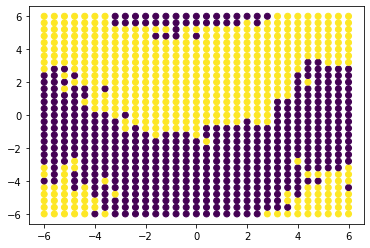

Step: 10, Cost:  0.290107421875


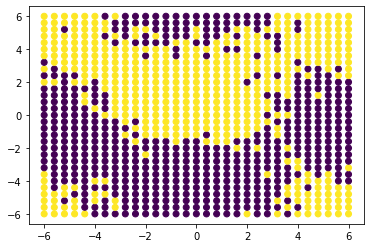

Step: 20, Cost:  0.2328900146484375


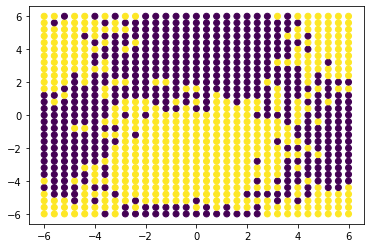

Step: 30, Cost:  0.25678680419921873


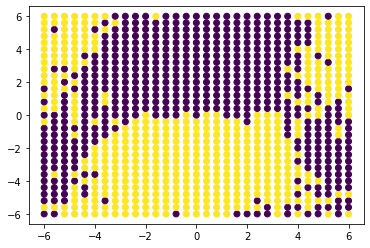

Step: 40, Cost:  0.233067626953125


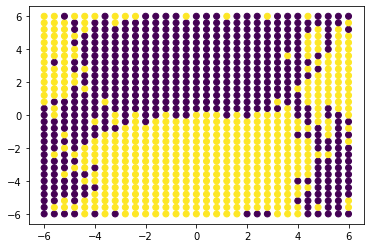

Step: 50, Cost:  0.19262298583984375


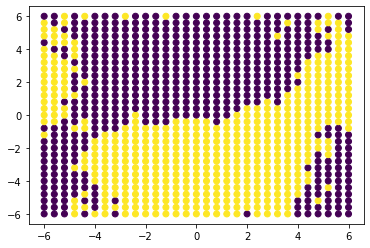

Step: 60, Cost:  0.18128143310546874


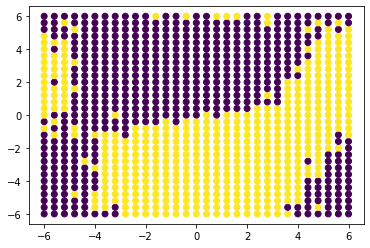

Step: 70, Cost:  0.14228118896484376


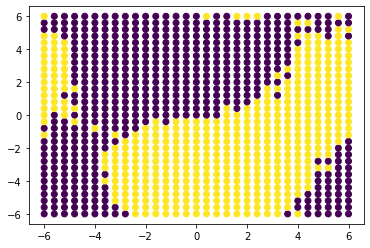

Step: 80, Cost:  0.15834228515625


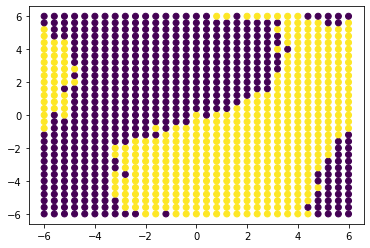

Step: 90, Cost:  0.09670196533203125


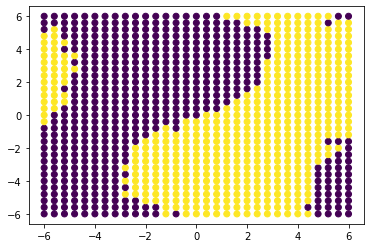

Step: 100, Cost:  0.10645416259765625


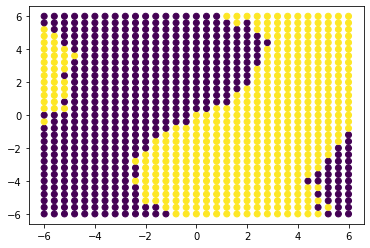

Step: 110, Cost:  0.1048388671875


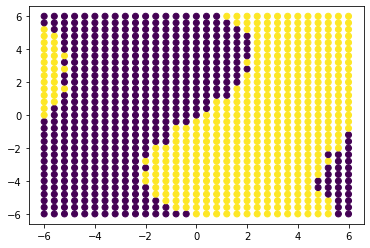

Final cost: 0.07405670166015625


In [48]:
params = initial_params

batch_size = 50

for j in range(120):
    # Get a batch of data
    batch_idx = np.random.choice(range(len(train_labels)), batch_size, replace=False)
    batch_features = train_coordinates[batch_idx]
    batch_labels = train_labels[batch_idx]

    params, prev_cost = opt.step_and_cost(lambda p: cost_2(p, batch_features, batch_labels), params)
    
    current_cost = cost_2(params, batch_features, batch_labels)
    if j % 10 == 0:
        print(f"Step: {j}, Cost: ", current_cost)
        
        n_size = 30
        grid_data = np.array([[12 * j / n_size, 12 * k / n_size] for j in range(-n_size // 2, n_size // 2 + 1, 1) for k in range(-n_size // 2, n_size // 2 + 1, 1)])
        predictions = [variational_classifier_2(params, f) for f in grid_data.reshape(-1, 1, 2)]
        pred_labels = 1 * (np.array(predictions) > 0.5)
        plt.scatter(x=grid_data[:,0], y=grid_data[:,1], c=pred_labels)
        plt.show()
    
    #if abs(current_cost - prev_cost) < 0.001 or current_cost < 0.3:
    #    break
print(f"Final cost: {current_cost}")

In [49]:
train_predictions = [variational_classifier_2(params, f) for f in train_coordinates]
test_predictions = [variational_classifier_2(params, f) for f in test_coordinates]

In [50]:
pred_labels = 1 * (np.array(train_predictions) > 0.5)

print(confusion_matrix(y_true=train_labels, y_pred=pred_labels))

print(classification_report(y_true=train_labels, y_pred=pred_labels))

[[1545  183]
 [  71 1249]]
              precision    recall  f1-score   support

           0       0.96      0.89      0.92      1728
           1       0.87      0.95      0.91      1320

    accuracy                           0.92      3048
   macro avg       0.91      0.92      0.92      3048
weighted avg       0.92      0.92      0.92      3048



In [51]:
pred_labels = 1 * (np.array(test_predictions) > 0.5)

print(confusion_matrix(y_true=test_labels, y_pred=pred_labels))

print(classification_report(y_true=test_labels, y_pred=pred_labels))

[[404  48]
 [ 21 289]]
              precision    recall  f1-score   support

           0       0.95      0.89      0.92       452
           1       0.86      0.93      0.89       310

    accuracy                           0.91       762
   macro avg       0.90      0.91      0.91       762
weighted avg       0.91      0.91      0.91       762



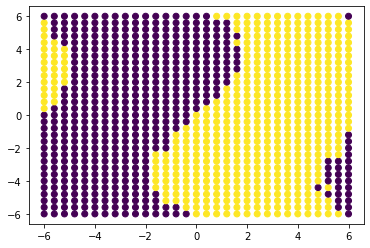

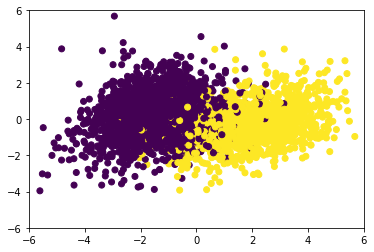

In [52]:
n_size = 30
grid_data = np.array([[12 * j / n_size, 12 * k / n_size] for j in range(-n_size // 2, n_size // 2 + 1, 1) for k in range(-n_size // 2, n_size // 2 + 1, 1)])
predictions = [variational_classifier_2(params, f) for f in grid_data.reshape(-1, 1, 2)]
pred_labels = 1 * (np.array(predictions) > 0.5)

plt.scatter(x=grid_data[:,0], y=grid_data[:,1], c=pred_labels)
plt.show()

plt.scatter(x=train_coordinates.reshape(-1,2)[:,0], y=train_coordinates.reshape(-1,2)[:,1], c=train_labels)
plt.xlim(-6,6)
plt.ylim(-6,6)
plt.show()

Classical comparison

In [53]:
X_train = train_coordinates.reshape(-1, n_components)
X_test = test_coordinates.reshape(-1, n_components)
y_train = train_labels
y_test = test_labels

clf = svm.SVC()
clf.fit(X_train, y_train)
 
pred_classic = clf.predict(X_train)
print(confusion_matrix(y_true=train_labels, y_pred=pred_classic))
print(classification_report(y_true=train_labels, y_pred=pred_classic))

pred_classic = clf.predict(X_test)
print(confusion_matrix(y_true=test_labels, y_pred=pred_classic))
print(classification_report(y_true=test_labels, y_pred=pred_classic))

[[1622  106]
 [ 117 1203]]
              precision    recall  f1-score   support

           0       0.93      0.94      0.94      1728
           1       0.92      0.91      0.92      1320

    accuracy                           0.93      3048
   macro avg       0.93      0.93      0.93      3048
weighted avg       0.93      0.93      0.93      3048

[[420  32]
 [ 32 278]]
              precision    recall  f1-score   support

           0       0.93      0.93      0.93       452
           1       0.90      0.90      0.90       310

    accuracy                           0.92       762
   macro avg       0.91      0.91      0.91       762
weighted avg       0.92      0.92      0.92       762



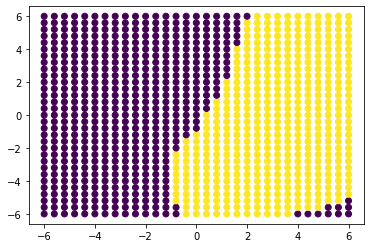

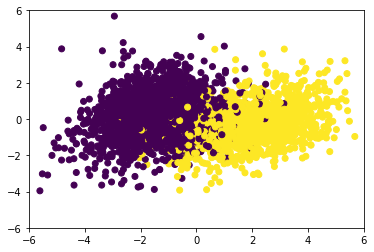

In [55]:
n_size = 30
grid_data = np.array([[12 * j / n_size, 12 * k / n_size] for j in range(-n_size // 2, n_size // 2 + 1, 1) for k in range(-n_size // 2, n_size // 2 + 1, 1)])
predictions = clf.predict(grid_data)
pred_labels = 1 * (np.array(predictions) > 0.5)

plt.scatter(x=grid_data[:,0], y=grid_data[:,1], c=pred_labels)
plt.show()

plt.scatter(x=train_coordinates.reshape(-1,2)[:,0], y=train_coordinates.reshape(-1,2)[:,1], c=train_labels)
plt.xlim(-6,6)
plt.ylim(-6,6)
plt.show()

In [54]:
#energy_expval = qml.ExpvalCost(circuit, h, simulator, optimize=True)